In [1]:
import os, sys
sys.path.insert(0, os.path.abspath("../src"))

In [2]:
from qudit_sim.circuit import QuantumCircuit
from qudit_sim.tableau import Tableau
from qudit_sim.utils import *

## Test for GHZ state

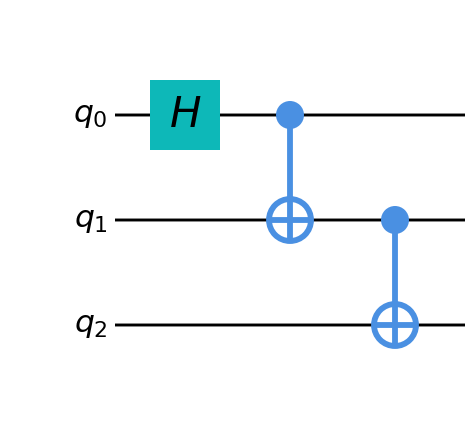

In [3]:
n, d = 3, 2

qc = QuantumCircuit(n, d)
qc.H(0)
qc.CX(0, 1)
qc.CX(1, 2)
qc.draw()

In [4]:
tab = Tableau(n, d, full=True)

tab.apply_circuit(qc)
print(tab)

#  | x0 x1 x2 | z0 z1 z2 | τ
────────────────────────────
d0 |  0  0  0 |  1  0  0 | 0
d1 |  0  1  1 |  0  0  0 | 0
d2 |  0  0  1 |  0  0  0 | 0
----------------------------
s0 |  1  1  1 |  0  0  0 | 0
s1 |  0  0  0 |  1  1  0 | 0
s2 |  0  0  0 |  0  1  1 | 0


In [5]:
k, r = schmidt_rank_vector(tab)

print(f'k-vector: {k}')
print(f'Schmidt rank vector: {r}')

k-vector: [1 1 1]
Schmidt rank vector: [2 2 2]


**This is correct**

## Bell pair + $|0\rangle$

In [6]:
n, d = 3, 2

qc = QuantumCircuit(n, d)
qc.H(0)
qc.CX(0, 1)

tab = Tableau(n, d, full=True)
tab.apply_circuit(qc)

k, r = schmidt_rank_vector(tab)

print(f'k-vector: {k}')
print(f'Schmidt rank vector: {r}')

k-vector: [1 1 0]
Schmidt rank vector: [2 2 1]


**Correct**

## Product state

In [7]:
n, d = 10, 5

qc = QuantumCircuit(n, d)
tab = Tableau(n, d, full=False)
tab.apply_circuit(qc)

k, r = schmidt_rank_vector(tab)

print(f'k-vector: {k}')
print(f'Schmidt rank vector: {r}')

k-vector: [0 0 0 0 0 0 0 0 0 0]
Schmidt rank vector: [1 1 1 1 1 1 1 1 1 1]


**Correct**

## 4-qubit GHZ

In [8]:
n, d = 4, 2

qc = QuantumCircuit(n, d)
qc.H(0)
qc.CX(0, 1)
qc.CX(1, 2)
qc.CX(2, 3)
tab = Tableau(n, d, full=False)
tab.apply_circuit(qc)

k, r = schmidt_rank_vector(tab)

print(f'k-vector: {k}')
print(f'Schmidt rank vector: {r}')

k-vector: [1 1 1 1]
Schmidt rank vector: [2 2 2 2]


**Correct**

## GHZ state for d=3,5

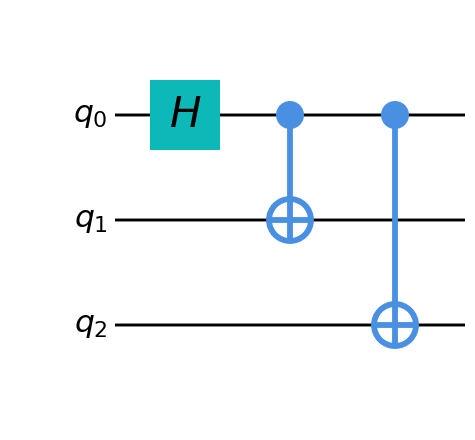

k-vector: [1 1 1]
Schmidt rank vector: [3 3 3]


In [9]:
n, d = 3, 3

qc = QuantumCircuit(n, d)
qc.H(0)
qc.CX(0, 1)
qc.CX(0, 2)
qc.draw()

tab = Tableau(n, d, full=True)
tab.apply_circuit(qc)

k, r = schmidt_rank_vector(tab)

print(f'k-vector: {k}')
print(f'Schmidt rank vector: {r}')

**Correct**

In [10]:
n, d = 3, 5

qc = QuantumCircuit(n, d)
qc.H(0)
qc.CX(0, 1)
qc.CX(0, 2)

tab = Tableau(n, d, full=True)
tab.apply_circuit(qc)

k, r = schmidt_rank_vector(tab)

print(f'k-vector: {k}')
print(f'Schmidt rank vector: {r}')

k-vector: [1 1 1]
Schmidt rank vector: [5 5 5]


In [11]:
n, d = 3, 2

qc = QuantumCircuit(n, d)
qc.H(0)
qc.CX(0, 1)
qc.CX(0, 2)

tab = Tableau(n, d, full=True)
tab.apply_circuit(qc)

k, r = schmidt_rank_vector(tab)

print(f'k-vector: {k}')
print(f'Schmidt rank vector: {r}')

k-vector: [1 1 1]
Schmidt rank vector: [2 2 2]


In [12]:
import numpy as np

def partial_trace(rho, keep, dims=None):
    """
    Partial trace of a density matrix.

    Parameters
    ----------
    rho : array_like, shape (D, D)
        Density matrix on ⊗_k C^{d_k}, with D = ∏_k d_k.
    keep : iterable of int
        Subsystems to keep (0-based indices). All others are traced out.
    dims : iterable of int, optional
        Local dimensions [d_0, d_1, ...]. If None, assume n qubits (all d_k = 2).

    Returns
    -------
    rho_red : ndarray
        Reduced density matrix on subsystems in `keep`, in that order.
    """
    rho = np.asarray(rho)
    if rho.ndim != 2 or rho.shape[0] != rho.shape[1]:
        raise ValueError("rho must be a square matrix")

    D = rho.shape[0]

    # infer local dims if not given (assume qubits)
    if dims is None:
        n = int(round(np.log2(D)))
        if 2**n != D:
            raise ValueError("Dimension is not a power of 2; please provide dims")
        dims = [2] * n
    else:
        dims = list(dims)
        if np.prod(dims) != D:
            raise ValueError("Product of dims must equal matrix dimension")

    n = len(dims)
    keep = list(keep)

    if any(k < 0 or k >= n for k in keep):
        raise ValueError("keep indices out of range")
    if len(set(keep)) != len(keep):
        raise ValueError("keep indices must be unique")

    trace = [i for i in range(n) if i not in keep]

    # reshape to 2n indices: (ket_0,...,ket_{n-1}, bra_0,...,bra_{n-1})
    rho_reshaped = rho.reshape(dims + dims)

    # permute to: (ket_keep, ket_trace, bra_keep, bra_trace)
    axes = keep + trace + [k + n for k in keep] + [t + n for t in trace]
    rho_perm = np.transpose(rho_reshaped, axes=axes)

    dim_keep = int(np.prod([dims[i] for i in keep])) if keep else 1
    dim_trace = int(np.prod([dims[i] for i in trace])) if trace else 1

    rho_perm = rho_perm.reshape(dim_keep, dim_trace, dim_keep, dim_trace)

    # trace over traced subsystems (ket_trace vs bra_trace)
    rho_red = np.trace(rho_perm, axis1=1, axis2=3)

    return rho_red


In [13]:
def kron_chain(mats):
    result = mats[0]
    for mat in mats[1:]:
        result = np.kron(result, mat)
    return result

H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
CX = np.array([[1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 0, 1],
                [0, 0, 1, 0]])
px = np.array([[0, 1], [1, 0]])
zero = np.array([1, 0])
one = np.array([0, 1])
P00 = np.outer(zero, zero)
P11 = np.outer(one, one)

state000 = np.kron(np.kron(zero, zero), zero)

HII = kron_chain([H, np.eye(2), np.eye(2)])
CX12 = np.kron(CX, np.eye(2))
CX23 = kron_chain([P00, np.eye(2), np.eye(2)]) + kron_chain([P11, np.eye(2), px])

final_state = CX23 @ CX12 @ HII @ state000
print('Final state vector:')
print(final_state)

rho = np.outer(final_state, np.conj(final_state))

rho1 = partial_trace(rho, keep=[0], dims=[2, 2, 2])
rho2 = partial_trace(rho, keep=[1], dims=[2, 2, 2])
rho3 = partial_trace(rho, keep=[2], dims=[2, 2, 2])

def rank_eig(rho, tol=1e-12):
    w = np.linalg.eigvalsh(rho)
    return np.sum(w > tol)


r1 = rank_eig(rho1)
r2 = rank_eig(rho2)
r3 = rank_eig(rho3)
print(f'Schmidt ranks from density matrices: {r1}, {r2}, {r3}')


Final state vector:
[0.70710678 0.         0.         0.         0.         0.
 0.         0.70710678]
Schmidt ranks from density matrices: 2, 2, 2


**Correct**

## Partition with sets of different sizes

In [14]:
n, d = 4, 5

qc = QuantumCircuit(n, d)
qc.H(0)
qc.CX(0, 1)
qc.CX(0, 2)

tab = Tableau(n, d, full=True)
tab.apply_circuit(qc)

k, r = schmidt_rank(tab, {2, 3, 1, 0}, {})

print(f'k: {k}')
print(f'Schmidt rank: {r}')

k: 0
Schmidt rank: 1


**Correct**

In [15]:
k, r = schmidt_rank(tab, {0, 1}, {2, 3})

print(f'k: {k}')
print(f'Schmidt rank: {r}')

k: 1
Schmidt rank: 5


**Correct**

In [16]:
n=2
d=2

X = np.array([[0, 1], [1, 0], [1, 0], [0, 1]])
Z = np.array([[0, 1], [1, 0], [1, 0], [0, 1]])
tau_exp = np.array([0,0,0,0])
tab = Tableau(n,d, X=X, Z=Z, tau_exp=tau_exp, full=True)

print(tab)

k, r = schmidt_rank_vector(tab)

print(f'k: {k}')
print(f'Schmidt rank vector: {r}')


#  | x0 x1 | z0 z1 | τ
──────────────────────
d0 |  0  1 |  0  1 | 0
d1 |  1  0 |  1  0 | 0
----------------------
s0 |  1  0 |  1  0 | 0
s1 |  0  1 |  0  1 | 0
k: [0 0]
Schmidt rank vector: [1 1]
